In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import itertools
import matplotlib.pyplot as plt

## Define arm model(look at writeup for details)

$\mathrm{cos}(\theta_2 + \mathrm{acos} \frac{\mathbf{R} \cdot (1, 0)}{|\mathbf{R}|}) = \frac{{|\mathbf{R}|}^2 + x^2 - y^2}{2x\mathbf{R}}$

$\theta_2 =  \mathrm{acos} \frac{{|\mathbf{R}|}^2 + x^2 - y^2}{2x\mathbf{R}} - \mathrm{acos} \frac{\mathbf{R} \cdot (1, 0)}{|\mathbf{R}|}$

$\angle OQR = \mathrm{acos} \frac{x^2 + y^2 - {|\mathbf{R}|}^2}{2xy}$

In [27]:
def calculate_angles(P, alpha, x, y, theta_1):
    u = np.array([1, 0])
    v = np.array([0, 1])
    R = P + np.array([alpha * np.cos(np.radians(180) - theta_1), alpha * np.sin(np.radians(180) - theta_1)])
    if(max(x, y, norm(R)) > sum([x, y, norm(R)]) - max(x, y, norm(R))):
        #print("not a triangle!")
        return None, None
    if(abs((norm(R) ** 2 + x ** 2 - y ** 2) / (2 * x * norm(R))) > 1):
        print("invalid theta for", x, y, norm(R))
        
    qor = np.arccos((norm(R) ** 2 + x ** 2 - y ** 2) / (2 * x * norm(R)))
    oqr = np.arccos((x ** 2 + y ** 2  - norm(R) ** 2)/(2 * x * y))
    
    
    theta_R = np.arccos(np.dot(R, u)/norm(R))
    theta_R = 2 * np.pi - theta_R if np.dot(R, v) < 0 else theta_R


    rotation_matrix = np.array([[np.cos(np.pi/2), -np.sin(np.pi/2)],
                                [np.sin(np.pi/2), np.cos(np.pi/2)]])
    

    if np.dot(np.array([x * np.cos(theta_R - qor), x * np.sin(theta_R - qor)]), rotation_matrix @ R) > 0:
        theta_2 = theta_R - qor
    elif np.dot(np.array([x * np.cos(theta_R + qor), x * np.sin(theta_R + qor)]), rotation_matrix @ R) > 0: 
        theta_2 = theta_R + qor
    else:
        return None, None
    
    Q = np.array([x * np.cos(theta_2), y * np.sin(theta_2)])

    return np.pi - theta_2, oqr

## Define measured locations

In [28]:
P = np.array([25.5, 9])

## 1. Gridsearch $x, y, \alpha$

### Define length bounds
$x_{min} <= x <= x_{max}$

$y_{min} <= y <= y_{max}$

$-\theta_{limit} <= \theta_1 <= \theta_{limit}$

In [29]:
xmin = 3
xmax = 14
ymin = 3
ymax = 14
alpha_min = 30
alpha_max = 40
theta_limit = np.deg2rad(10)

In [30]:
x_grid = list(np.linspace(xmin, xmax, 20))  # too lazy to vectorize the simulation
y_grid = list(np.linspace(ymin, ymax, 20))
alpha_grid = list(np.linspace(alpha_min, alpha_max, 10))
combinations = list(itertools.product(x_grid, y_grid, alpha_grid))
len(combinations)

4000

### Perform grid search

In [31]:
result_df = pd.DataFrame({"x": [i[0] for i in combinations], "y": [i[1] for i in combinations], "alpha": [i[2] for i in combinations]})
# below are result columns
result_df.head()

,x,y,alpha
0,3.0,3.0,30.000000
1,3.0,3.0,31.111111
2,3.0,3.0,32.222222
3,3.0,3.0,33.333333
4,3.0,3.0,34.444444


In [33]:
%%time
theta2_mins = []
theta2_maxs = []
oqr_mins = []
oqr_maxs = []
dtheta_maxs = []
dtheta_sums = []
theta2_at_theta1_0 = []
oqr_at_theta1_0 = []
for index, row in result_df.iterrows():
    x = row["x"]
    y = row["y"]
    alpha = row["alpha"]
    theta2_min = float("inf")
    theta2_max = float("-inf")
    oqr_min = float("inf")
    oqr_max = float("-inf")
    dtheta = []
    theta2_prev = 0
    thetas = list(np.linspace(-theta_limit, theta_limit))
    for index, theta_1 in enumerate(thetas):  # almost same performance as np.vectorize
        theta2, oqr = calculate_angles(P, alpha, x, y, theta_1)
        if not theta2 or not oqr:
            theta2_min = np.nan
            theta2_max = np.nan
            oqr_min = np.nan
            oqr_max = np.nan
            dtheta_sum = np.nan
            break
        theta2_min = min(theta2_min, theta2)
        theta2_max = max(theta2_max, theta2)
        oqr_min = min(oqr_min, oqr)
        oqr_max = max(oqr_max, oqr)
        if index > 0:
            dtheta.append((theta2 - theta2_prev) / (theta_1 - thetas[index - 1]))
        theta2_prev = theta2
    
    if np.isnan(theta2_min):
        dtheta_maxs.append(np.nan)
        dtheta_sums.append(np.nan)
        theta2_mins.append(theta2_min)
        theta2_maxs.append(theta2_max)
        oqr_mins.append(oqr_min)
        oqr_maxs.append(oqr_max)
        theta2_at_theta1_0.append(np.nan)
        oqr_at_theta1_0.append(np.nan)
    else:
        dtheta_maxs.append(np.rad2deg(max(dtheta)))
        dtheta_sums.append(sum(dtheta))
        theta2_mins.append(np.rad2deg(theta2_min))
        theta2_maxs.append(np.rad2deg(theta2_max))
        oqr_mins.append(np.rad2deg(oqr_min))
        oqr_maxs.append(np.rad2deg(oqr_max))
        t0, o0  = calculate_angles(P, alpha, x, y, 0)
        theta2_at_theta1_0.append(np.rad2deg(t0))
        oqr_at_theta1_0.append(np.rad2deg(o0))
        

        
result_df["theta2_min"] = theta2_mins
result_df["theta2_max"] = theta2_maxs
result_df["theta2@0"] = theta2_at_theta1_0
result_df["oqr@0"] = oqr_at_theta1_0
result_df["oqr_min"] = oqr_mins
result_df["oqr_max"] = oqr_maxs
result_df["dtheta_max"] = dtheta_maxs
result_df["dtheta_sum"] = dtheta_sums
result_df = result_df.copy()

CPU times: user 9.68 s, sys: 0 ns, total: 9.68 s
Wall time: 9.67 s


In [34]:
result_df = result_df.loc[np.logical_not(np.isnan(result_df["theta2_min"]))]
result_df

,x,y,alpha,theta2_min,theta2_max,theta2@0,oqr@0,oqr_min,oqr_max,dtheta_max,dtheta_sum
595,4.157895,14.000000,35.555556,-149.727067,40.455945,-46.433239,74.468477,9.689826,157.436456,1219.221137,465.948380
752,4.736842,11.684211,32.222222,-132.428586,43.286076,-30.225156,72.779676,11.369827,147.073377,1230.350726,430.500920
763,4.736842,12.263158,33.333333,-123.870272,41.123428,-33.709313,74.799399,20.494848,148.972006,787.960203,404.234565
774,4.736842,12.842105,34.444444,-117.746855,40.532249,-35.959494,77.489500,28.092952,152.581473,702.780399,387.783804
784,4.736842,13.421053,34.444444,-136.671398,28.389333,-43.241839,70.921684,15.481686,136.868706,890.485629,404.398791
...,...,...,...,...,...,...,...,...,...,...,...
3995,14.000000,14.000000,35.555556,-52.696759,7.676451,-19.356879,57.627400,41.526158,79.534777,217.179447,147.914366
3996,14.000000,14.000000,36.666667,-53.083033,7.208338,-20.320664,61.623116,45.959802,83.659941,207.866423,147.713857
3997,14.000000,14.000000,37.777778,-52.947800,7.107205,-20.822667,65.869472,50.552284,88.113427,199.247091,147.134762
3998,14.000000,14.000000,38.888889,-52.392048,7.367226,-20.909709,70.362660,55.299553,92.916820,191.448796,146.410219


### condition 1: min, max angle of $\theta_2$

$-60° <= \theta_2 <= 60°$

-55 is the lowest the lower arm can go before hitting the backplate. 50 seems like a reasonable max angle

In [35]:
cond1 = result_df.loc[np.logical_and(result_df["theta2_min"] >= -55, result_df["theta2_max"] <= 50)]
cond1

,x,y,alpha,theta2_min,theta2_max,theta2@0,oqr@0,oqr_min,oqr_max,dtheta_max,dtheta_sum
1510,7.052632,9.368421,30.000000,-52.214576,43.985083,-0.113403,74.075272,36.091351,127.671276,397.777381,235.689165
1511,7.052632,9.368421,31.111111,-54.148706,45.567659,-2.093091,79.084757,42.027116,136.797968,371.893340,244.305094
1512,7.052632,9.368421,32.222222,-54.237442,49.673521,-2.949657,85.086372,48.784565,149.933395,459.869180,254.581859
1700,7.631579,8.789474,30.000000,-38.898365,46.194448,5.809545,75.210386,38.650119,128.094456,327.908078,208.477390
1701,7.631579,8.789474,31.111111,-42.741405,47.348891,3.326863,80.123364,44.217155,137.139133,328.367283,220.721226
...,...,...,...,...,...,...,...,...,...,...,...
3995,14.000000,14.000000,35.555556,-52.696759,7.676451,-19.356879,57.627400,41.526158,79.534777,217.179447,147.914366
3996,14.000000,14.000000,36.666667,-53.083033,7.208338,-20.320664,61.623116,45.959802,83.659941,207.866423,147.713857
3997,14.000000,14.000000,37.777778,-52.947800,7.107205,-20.822667,65.869472,50.552284,88.113427,199.247091,147.134762
3998,14.000000,14.000000,38.888889,-52.392048,7.367226,-20.909709,70.362660,55.299553,92.916820,191.448796,146.410219


### condition2 : min, max angle of OQR

In [36]:
cond2 = cond1.loc[np.logical_and(result_df["oqr_min"] >= 55, result_df["oqr_max"] <= 100)]
cond2

,x,y,alpha,theta2_min,theta2_max,theta2@0,oqr@0,oqr_min,oqr_max,dtheta_max,dtheta_sum
3577,12.842105,12.842105,37.777778,-50.482671,12.344607,-17.408275,72.698258,55.482542,98.588231,202.930139,153.926831
3767,13.421053,12.263158,37.777778,-45.671395,14.519440,-13.971786,72.539628,55.260383,98.487859,195.642679,147.467547
3788,13.421053,13.421053,38.888889,-51.089329,10.034212,-19.148037,73.886003,57.904989,98.250793,193.201581,149.752677
3798,13.421053,14.000000,38.888889,-54.029290,7.544618,-21.733212,72.042162,56.523285,95.470114,195.328018,150.856073
3978,14.000000,12.842105,38.888889,-46.709671,12.129522,-15.927513,73.743909,57.711706,98.158360,187.280264,144.156025
3988,14.000000,13.421053,38.888889,-49.531074,9.743128,-18.406704,72.042162,56.523285,95.470114,189.332440,145.221793
3998,14.000000,14.000000,38.888889,-52.392048,7.367226,-20.909709,70.362660,55.299553,92.916820,191.448796,146.410219
3999,14.000000,14.000000,40.000000,-51.486898,7.989801,-20.619071,75.106966,60.204933,98.105254,184.485718,145.717913


## optimal values:
$\alpha = 30$

$x = 7.05$

$y = 10.5$

## 2. Verify optimal values are valid

In [49]:
import matplotlib.animation as animation

0.4359091055281761 2.688027078312154


In [88]:
alpha = 32
x = 8
y = 10

<IPython.core.display.Javascript object>


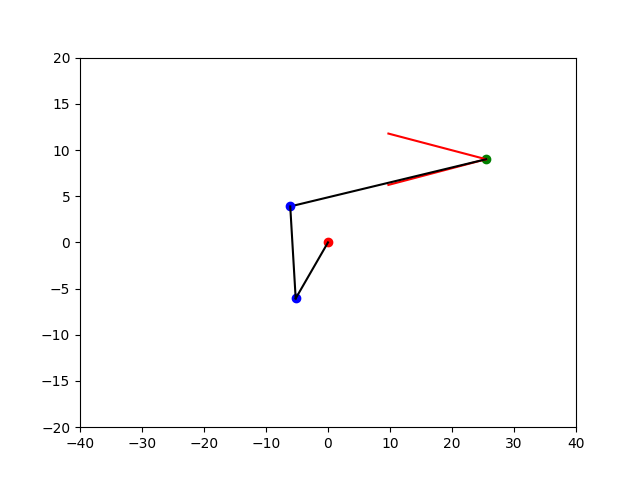

In [92]:
%matplotlib notebook


fig, ax = plt.subplots()
ax.set_xlim([-40, 40])
ax.set_ylim([-20, 20])

n_thetas = 50
max_theta1_angle = np.deg2rad(10)
thetas = np.linspace(-max_theta1_angle, max_theta1_angle, n_thetas)

last_successful_i = 0
def plot_2_points(a, b, ax, color="k"):
    xvals = [a[0], b[0]]
    yvals = [a[1], b[1]]
    ax.plot(xvals, yvals, f"{color}-")

def update_simulation(i):
    ax.clear()
    ax.set_xlim([-40, 40])
    ax.set_ylim([-20, 20])
    origin = np.array([0, 0])
    ax.plot(*origin, "ro", label="O")
    ax.plot(*P, "go", label="O")
    #plot_2_points(origin, P, ax)
    plot_2_points(P, P + np.array([alpha/2 * np.cos(np.radians(180) + max_theta1_angle), alpha/2 * np.sin(np.radians(180) + max_theta1_angle)]), ax, "r")
    plot_2_points(P, P + np.array([alpha/2 * np.cos(np.radians(180) - max_theta1_angle), alpha/2 * np.sin(np.radians(180) - max_theta1_angle)]), ax, "r")
    
    theta2, oqr = calculate_angles(P, alpha, x, y, thetas[i])

    if not theta2:
        theta2, oqr = calculate_angles(P, alpha, x, y, thetas[last_successful_i])
        R = P + np.array([alpha * np.cos(np.radians(180) - thetas[last_successful_i]), alpha * np.sin(np.radians(180) - thetas[last_successful_i])])
    else:
        last_successful_i = i
        R = P + np.array([alpha * np.cos(np.radians(180) - thetas[i]), alpha * np.sin(np.radians(180) - thetas[i])])
        
    plot_2_points(P, R, ax)
    ax.plot(*R, "bo", label="O")
    
    Q = origin + np.array([x * np.cos(-theta2 - np.pi), x * np.sin(- theta2 - np.pi)])
    ax.plot(*Q, "bo", label="O")
    plot_2_points(origin, Q, ax)
    
    plot_2_points(Q, R, ax)


anim = animation.FuncAnimation(fig, update_simulation, frames=n_thetas, interval=50)
#writer = animation.writers['ffmpeg']
#anim.save("test3.mp4", writer="ffmpeg")